In [1]:
import yaml
import os 
import gzip
import cloudpickle

import awkward as ak
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep

import hist
from hist import Hist

# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# from topcoffea.modules.histEFT import HistEFT
# NanoAODSchema.warn_missing_crossrefs = False

# from coffea.analysis_tools import PackedSelection
from topcoffea.modules import utils
import topcoffea.modules.eft_helper as efth

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

import dctr.modules.plotting_tools as plt_tools
import dctr.modules.DNN_tools as DNN_tools

In [2]:
# def get_ratio_uncertainty(num_hist, denom_hist):
#     '''
#     Calculates the propagated uncertainty per bin on the ratio of two historgams

#     Parameters
#     ----------
#         num_hist (scikithep hist): numerator histogram
#         denom_hist (scikithep hist): Denominator histogram
    
#     Returns:
#         list of uncertainties, one entry per histogram bin
#     '''

#     xvals = num_hist.axes.centers[0]
#     yvals_num = num_hist.values()
#     yvals_denom = denom_hist.values()
#     sigma_num = np.sqrt(num_hist.variances())
#     sigma_denom = np.sqrt(denom_hist.variances())

#     ratio = np.divide(yvals_num, yvals_denom)

#     # calculation for error propagation for ratio = yavls_num/yvals_denom
#     # generally, z=x/y; sigma_z = abs(z)sqrt((sigma_x/x)^2+(sigma_y/y)^2)
#     sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))

#     return sigma_y

# def get_ratio_points(num_hist, denom_hist):
#     '''
#     Calculates the ratio between two histograms

#     Parameters
#     ----------
#         num_hist (scikithep hist): numerator histogram
#         denom_hist (scikithep hist): Denominator histogram

#     Returns:
#         centers: list of the x-axis point that the ratio corresponds to
#         ratio: list of the ratio value (one for each hist bin)
#     '''

#     num = num_hist.values()
#     centers = num_hist.axes.centers[0]
#     denom = denom_hist.values()
#     ratio = np.divide(num, denom)

#     return centers, ratio

In [3]:
# f_smeft = "smeft_nosel_NOrwgt.pkl.gz"
# f_smeft_reweight = "smeft_nosel_rwgt.pkl.gz"
# f_powheg = "powheg_nosel.pkl.gz"

# smeft_hists = utils.get_hist_from_pkl(f_smeft, allow_empty=False)
# smeft_reweight_hists = utils.get_hist_from_pkl(f_smeft_reweight, allow_empty=False)
# powheg_hists = utils.get_hist_from_pkl(f_powheg, allow_empty=False)



In [4]:
# hist_list = ['NNoutput', 'reweights']
# # hist_list = ['NNoutput']
# for name in hist_list:
#     hep.style.use('CMS')
#     h = smeft_reweight_hists[name].as_hist({})
    
#     # print(h.values())
#     fig, ax = plt.subplots()
#     hep.style.use('CMS')
    
#     h.plot1d(ax=ax, yerr=False)
#     ax.set_xlim([0.8, 1])

In [5]:
def make_reweighted_plots(f_smeft, f_smeft_rwgt, f_powheg, outdir, title, figprefix, norm=False):
    
    smeft_hists = utils.get_hist_from_pkl(f_smeft, allow_empty=False)
    smeft_rwgt_hists = utils.get_hist_from_pkl(f_smeft_rwgt, allow_empty=False)
    powheg_hists = utils.get_hist_from_pkl(f_powheg, allow_empty=False)
    
    for name in powheg_hists.keys():
        h_smeft = smeft_hists[name].as_hist({})
        h_smeft_rwgt = smeft_rwgt_hists[name].as_hist({})
        h_powheg = powheg_hists[name].as_hist({})
        
        centers = h_powheg.axes.centers[1]
        edges = h_powheg.axes[1].edges

        h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
        h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())
        
        
        hep.style.use('CMS')
        # Initialize figure and axes
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(10,12),
            gridspec_kw={'height_ratios': (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.1)
        
        h_powheg.plot1d(ax=ax, density=norm, yerr=False, label='Powheg', color='black')
        h_smeft.plot1d(ax=ax, density=norm, stack=False, yerr=False, linewidth=2, label='SMEFT')
        h_smeft_rwgt.plot1d(ax=ax, density=norm, stack=False, yerr=False, linewidth=2, label='SMEFT rwgt')
        
        rax.scatter(centers, h_smeft_ratio, label='SMEFT')
        rax.scatter(centers, h_smeft_rwgt_ratio, label='SMEFT rwgt')
        
        ax.legend(loc='best')
        ax.set_title(title)
        ax.set_xlabel('')
        rax.set_xlabel(name)
        ax.set_ylabel('Events')

        rax.set_ylim([0.4, 1.6])
        rax.axhline(y=0.5, color='gray', linestyle='--')
        rax.axhline(y=1.0, color='gray', linestyle='--')
        rax.axhline(y=1.5, color='gray', linestyle='--')
        
        figname = os.path.join(outdir, f"{figprefix}_{name}")
        print(f"saving fig to {figname}.png")
        fig.savefig(f"{figname}.png", bbox_inches='tight')
        plt.close(fig)

In [6]:
# make_reweighted_plots(f_smeft = "smeft_nosel_NOrwgt.pkl.gz", 
#                       f_smeft_rwgt = "smeft_nosel_rwgt.pkl.gz", 
#                       f_powheg = "powheg_nosel.pkl.gz",
#                       outdir = "/users/hnelson2/dctr/analysis/180925_reweight_plots/small_network/", 
#                       title="small network - no selections", 
#                       figprefix="NOsel", 
#     )

# make_reweighted_plots(f_smeft = "smeft_selec_NOrwgt.pkl.gz", 
#                       f_smeft_rwgt = "smeft_selec_rwgt.pkl.gz", 
#                       f_powheg = "powheg_selec.pkl.gz",
#                       outdir = "/users/hnelson2/dctr/analysis/180925_reweight_plots/small_network/", 
#                       title="small network - with selections", 
#                       figprefix="SELEC", 
#     )

# make_reweighted_plots(f_smeft = "LARGE_smeft_selec_NOrwgt.pkl.gz", 
#                       f_smeft_rwgt = "LARGE_smeft_selec_rwgt.pkl.gz", 
#                       f_powheg = "LARGE_powheg_selec.pkl.gz",
#                       outdir = "/users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/", 
#                       title="large network - with selections", 
#                       figprefix="SELEC", 
#     )

make_reweighted_plots(f_smeft = "LARGE_smeft_nosel_NOrwgt.pkl.gz", 
                      f_smeft_rwgt = "LARGE_smeft_nosel_rwgt.pkl.gz", 
                      f_powheg = "LARGE_powheg_nosel.pkl.gz",
                      outdir = "/users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/", 
                      title="large network - no selections", 
                      figprefix="NOsel", 
    )

saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_sow.png
saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_pttt.png


/tmp/ipykernel_3868225/902616575.py:15: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_3868225/902616575.py:16: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_mtt.png
saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top1pt.png
saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top2pt.png
saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top1eta.png
saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top2eta.png


/tmp/ipykernel_3868225/902616575.py:15: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_3868225/902616575.py:16: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top1phi.png


/tmp/ipykernel_3868225/902616575.py:15: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_3868225/902616575.py:16: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top2phi.png


/tmp/ipykernel_3868225/902616575.py:15: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_3868225/902616575.py:16: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top1mass.png


/tmp/ipykernel_3868225/902616575.py:15: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_3868225/902616575.py:16: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_top2mass.png
saving fig to /users/hnelson2/dctr/analysis/180925_reweight_plots/large_network/NOsel_njets.png


smeft values for NNoutput: [[0.00000e+00 1.00000e+00 3.00000e+00 5.00000e+00 1.20000e+01 1.00000e+01
  1.10000e+01 1.50000e+01 1.90000e+01 2.70000e+01 3.70000e+01 3.30000e+01
  4.60000e+01 4.30000e+01 6.30000e+01 5.60000e+01 8.00000e+01 1.11000e+02
  1.17000e+02 1.43000e+02 1.58000e+02 2.05000e+02 2.50000e+02 3.13000e+02
  4.01000e+02 5.55000e+02 6.85000e+02 8.79000e+02 1.18900e+03 1.66600e+03
  2.23000e+03 3.34500e+03 4.76400e+03 6.94200e+03 1.01660e+04 1.48970e+04
  2.22500e+04 3.28680e+04 4.82760e+04 6.95330e+04 1.00787e+05 1.43328e+05
  2.03337e+05 2.85470e+05 3.98681e+05 5.36250e+05 6.83096e+05 8.09980e+05
  8.77414e+05 8.73729e+05 8.13543e+05 7.14414e+05 5.73695e+05 4.34000e+05
  3.15660e+05 2.22965e+05 1.55820e+05 1.09314e+05 7.84770e+04 5.82600e+04
  4.44080e+04 3.47050e+04 2.69960e+04 2.10490e+04 1.68600e+04 1.35590e+04
  1.07660e+04 8.91200e+03 7.27800e+03 5.94900e+03 4.66700e+03 3.84900e+03
  2.99700e+03 2.36500e+03 1.87900e+03 1.52000e+03 1.21000e+03 9.60000e+02
  7.48000e+

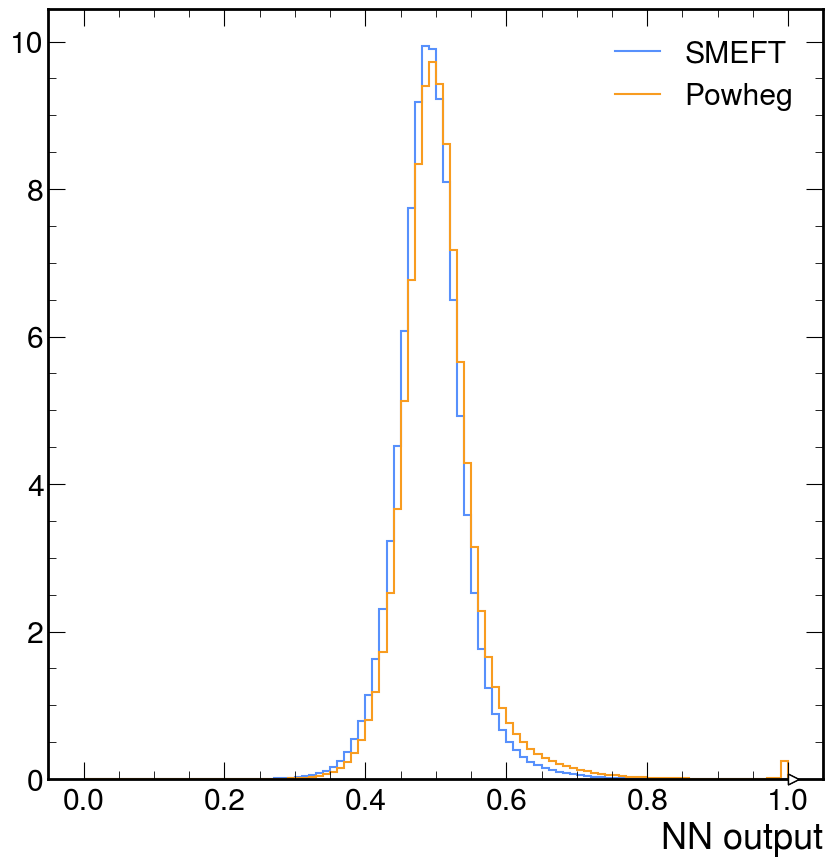

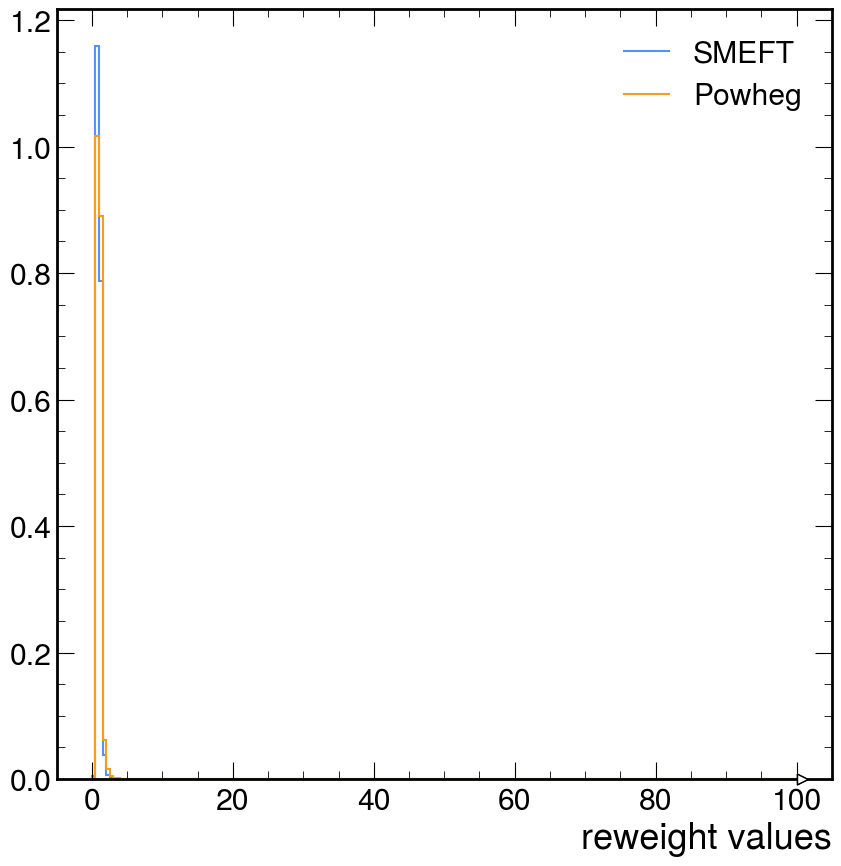

In [21]:
f_smeft_reweight = "LARGE_smeft_nosel_rwgt.pkl.gz"
f_powheg_reweight = "LARGE_powheg_nosel_rwgt.pkl.gz"
smeft_reweight_hists = utils.get_hist_from_pkl(f_smeft_reweight, allow_empty=True)
powheg_reweight_hists = utils.get_hist_from_pkl(f_powheg_reweight, allow_empty=False)


hist_list = ['NNoutput', 'reweights']
# # hist_list = ['NNoutput']
norm=True
for name in hist_list:
    h1= smeft_reweight_hists[name].as_hist({})
    h2 = powheg_reweight_hists[name].as_hist({})
    
    print(f"smeft values for {name}: {h1.values()}\n")
    print(f"powheg values for {name}: {h2.values()}\n")

    fig, ax = plt.subplots()
    hep.style.use('CMS')
    
    h1.plot1d(ax=ax, density=norm, yerr=False, label='SMEFT')
    h2.plot1d(ax=ax, density=norm, yerr=False, label='Powheg')
    
    ax.legend()
    
    # ax.set_ylim([0, 0.5])
    # ax.set_yscale('log')